#### IMPORTING LIBRARIES


In [1]:
import time 
start=time.time()
import pandas as pd 
import numpy as np 
import seaborn as sns  
import nltk 
from nltk  import FreqDist,pos_tag
from random import randint 
#nltk.download('stopwords')
from nltk.corpus import stopwords,wordnet
import matplotlib.pyplot as plt  
from wordcloud import STOPWORDS,WordCloud  
from matplotlib import rcParams
from nltk.tokenize import sent_tokenize, word_tokenize  
from nltk.stem.snowball import SnowballStemmer  
from nltk.stem import WordNetLemmatizer   
import spacy
from spacy import displacy  
from statistics import mode 
import  string as String  
from sklearn.datasets import load_linnerud
from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression 
from sklearn.datasets import load_diabetes 
from sklearn.decomposition import PCA  
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.neighbors import RadiusNeighborsRegressor 
from sklearn.cross_decomposition import PLSCanonical,PLSRegression
from sklearn.ensemble import ExtraTreesRegressor 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor  
from sklearn.multioutput import MultiOutputRegressor,MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.metrics import r2_score,confusion_matrix,ConfusionMatrixDisplay 
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from tqdm import tqdm 
import re as re 
import math  
import json

import os
import pathlib
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

2022-10-25 20:02:22.287941: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-25 20:02:26.433440: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-25 20:02:28.217829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-25 20:02:28.217873: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

#### LOADING AND PREPARING DATA

In [3]:
items = 3911

df_relevant=pd.read_csv("./newcsvs/relevant.csv")[:items]
df_train=pd.read_csv("./data/train.csv")[:items]
df_essays=pd.DataFrame(df_train["full_text"])[:items]
df_test=pd.read_csv("./data/test.csv")[:items]
y=df_train.drop(["text_id","full_text"],axis=1) 

essays=df_essays["full_text"]
essays=list(essays) 
essays=" ".join(essays)  
essays=('''"""''') +essays + ('''"""''')   
target_names=list(y)

## GLOBAL FUNCTIONS

In [5]:
english_words=[] 
file=open("./data/actual_all_words.txt","r")  
wfile=file.readlines() 
for word in wfile: 
    english_words.append(word.lower()) 
for i in range(0,len(english_words)):  
    english_words[i]=english_words[i].replace("\n","")
# Direct path if there are installation issues
# en_core_web_lg = "C:\ProgramData\Anaconda3\Lib\site-packages\en_core_web_lg\en_core_web_lg-3.4.1"
NER = spacy.load("en_core_web_lg")     

In [6]:
unwanted_list=["'s","`s","´s","'re","`re","´re","n't","n´t","n`t","'ll","´ll","`ll","'d","´d","`d","'ve","`ve","´ve","'m","`m","´m","'",'"',".",",","`","!","?","´",':',"(",")","/",";",'#']
unwanted_list.extend(list(String.punctuation)) 
unwanted_list=list(set(unwanted_list))
stop_words=stopwords.words("english")     
load_model = spacy.load("en_core_web_lg", disable = ['parser','ner']) 
load_model.max_length =len(essays) *2
def remove_unwanted(string,unwanted):  
    for i in unwanted:  
        if i == "'s" or i== '`s' or i == '´s':   
            if "let's" in string or "let´s" in string or "let`s" in string:
                string=string.replace("let's","lets")
                string=string.replace("let´s","lets")
                string=string.replace("let`s","lets")
            string=string.replace(i," is") 
        elif i == "'re" or i== '`re' or i == '´re': 
            string=string.replace(i," are") 
        elif i== "n't" or i == "n`t" or i== "n´t":  
            if "won't" in string or "won´t" in string or "won`t" in string:
                string=string.replace("won`t","wont")
                string=string.replace("won´t","wont")
                string=string.replace("won't","wont")
            string=string.replace(i," will not")   
        elif i == "'ll" or i == "´ll" or i == "`ll": 
            string=string.replace(i," will") 
        elif i == "'d" or i == "´d" or i == "`d": 
            string=string.replace(i," would")
        elif i == "'ve" or i == "´ve" or i == "`ve": 
            string=string.replace(i," have") 
        elif i == "'m" or i == "´m" or i == "`m": 
            string=string.replace(i," am") 
        else:
            string=string.replace(i," ")
    return string    
def filter_text(string,stop_words=stop_words,unique_words=False,filter_by_sw=True,remove_numbers=False,remove_numbers_and_words_glued=False): 
    string=remove_unwanted(string,unwanted_list)
    if remove_numbers: 
        string=removing_numbers(string) 
    if remove_numbers_and_words_glued: 
        string=removing_numbers(string,remove_text_next_to_num=True)
    tokenized=word_tokenize(string) 
    filtered=tuple(tokenized)
    if filter_by_sw:
        filtered=tuple([word.casefold() for word in tokenized if word.casefold() not in stop_words])
    if unique_words:
        filtered =tuple(set(filtered))
    return filtered 
def get_num_words(string,unique_words=True,filter_by_sw=True):  
    filtered=filter_text(string,unique_words=unique_words,filter_by_sw=filter_by_sw)
    return len(filtered)
def makeWordcloud(text,stopwords=STOPWORDS,maxwords=300,width=800,height=800,color="black",column="fulltext"): 
    if isinstance(text,pd.core.frame.DataFrame):  
        newtext="\n".join(text[column])
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()  
    elif isinstance(text,str):  
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()
    elif isinstance(text,list) or isinstance(text,np.ndarray) or isinstance(text,pd.core.series.Series): 
        newtext=" ".join(text)
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()  
def create_txt_with_example(specific=randint(0,len(df_train["full_text"]))): 
    newExample=open("./examples/example_%d.txt" % specific,"w") 
    newExample.write(df_train["full_text"][specific]) 
    newExample.close()  
def getcommonwords(text,amount=10):  
    filtered=filter_text(text,unique_words=False) 
    freq=FreqDist(filtered) 
    return tuple([word[0] for word in freq.most_common(amount)]) 
def pos_tag_text(text,filter=False,to_dic=False): 
    tagged=pos_tag(text) 
    return tagged
def mistakeCounter(essay): 
    filtered_text=filter_text(essay,filter_by_sw=False,unique_words=False)  
    a=[]
    for word in filtered_text: 
        if word.lower() not in english_words:  
           a.append(word)   
    NerText=NER(" ".join(a)) 
    for word in NerText.ents: 
        if word.label_ == "PERSON" or word.label_ == "ORG" or word.label_ == "LOC" or word.label_ == "DATE" or word.label_ == "MONEY"   or word.label_ == "PRODUCT" or word.label_ == "WORK_OF_ART" or word.label_ == "FAC" or word.label_ == "EVENT" or word.label_ == "GPE" or  word.label_ == "TIME" or  word.label_ == "PERCENT" or word.label_ == "NORP" :
            words=word_tokenize(word.text) 
            for j in words:  
                if j in a:
                    a.remove(j)
    final=a 
    return len(final)   
def mistakelist(essay):  
    filtered_text=filter_text(essay,filter_by_sw=False,unique_words=False)  
    a=[]
    for word in filtered_text: 
        if word.lower() not in english_words:  
           a.append(word)   
    NerText=NER(" ".join(a)) 
    for word in NerText.ents: 
        if word.label_ == "PERSON" or word.label_ == "ORG" or word.label_ == "LOC" or word.label_ == "DATE" or word.label_ == "MONEY"   or word.label_ == "PRODUCT" or word.label_ == "WORK_OF_ART" or word.label_ == "FAC" or word.label_ == "EVENT" or word.label_ == "GPE" or  word.label_ == "TIME" or  word.label_ == "PERCENT" or word.label_ == "NORP" :
            words=word_tokenize(word.text) 
            for j in words:  
                if j in a:
                    a.remove(j)
    final=a 
    return final 
def getradicals(essay): 
    doc=load_model(" ".join(filter_text(essay,unique_words=False))) 
    radicals=[token.lemma_ for token in doc] 
    final=radicals
    for word in radicals:
        if word not in english_words:
            if word in final: 
                final.remove(word)
    return final  
def amountRadicals(essay): 
    radicals=set(getradicals(essay))
    return len(radicals) 
def stop_words_counter(essay): 
    filtered=filter_text(essay,unique_words=False,filter_by_sw=False)  
    a=[]
    for word in filtered: 
        if word.lower() in stop_words: 
            a.append(word.lower()) 
    return len(a);  
def removing_numbers(essay,remove_text_next_to_num=False): 
    newessay=""
    if(remove_text_next_to_num): 
        newessay=re.sub(r"\d\w* | [\s]+ |\d+" ,"",essay) 
    else:
        newessay=re.sub(r"\d*" ,"",essay) 
    return newessay 
def padronizingpred(num): 
    if num < 1.0 or num > 5.0: 
        if num < 1: 
            return 1.0 
        else: 
            return 5.0  
    numfloor=float(math.floor(num))
    numceil=float(math.ceil(num))
    halfway=numceil-0.5  
    if num >= halfway :
        subhalfway=halfway+0.25 
        if num > subhalfway: 
            return numceil 
        else: 
            return halfway
    else: 
        subhalfway=halfway-0.25
        if num > subhalfway: 
            return halfway
        else: 
            return numfloor

## EMBEDDING TEXT

### Embedder Functions

#### Bag of Words

In [7]:
def transform_to_bag_of_words(essay): 
    vectorizer=CountVectorizer(tokenizer=lambda text : filter_text(text,unique_words=False,filter_by_sw=True,remove_numbers_and_words_glued=True),stop_words=stop_words,max_features=20000) 
    if isinstance(essay,pd.core.frame.DataFrame)or isinstance(essay,pd.core.series.Series) :   
        bag=vectorizer.fit_transform(essay["full_text"]).toarray() 
        colnames=df_relevant.iloc[:,8:].columns
        new_cols=essay.loc[:,colnames].copy() 
        for i in colnames:  
            if i != "most_common_words":
                bag=np.c_[bag,essay[i]]
        return bag,vectorizer.get_feature_names_out()
    elif isinstance(essay,list):
        bag=vectorizer.fit_transform(essay).toarray() 
        return bag,vectorizer.get_feature_names_out()
    else: 
        bag=vectorizer.fit_transform([essay]).toarray()
        return bag,vectorizer.get_feature_names_out()

#### TF-IDF

In [8]:
def transform_to_tfidf(essay): 
    vectorizer=TfidfVectorizer(tokenizer=lambda text : filter_text(text,unique_words=False,filter_by_sw=True,remove_numbers_and_words_glued=True),stop_words=stop_words,max_features=20000) 
    if isinstance(essay,pd.core.frame.DataFrame)or isinstance(essay,pd.core.series.Series) :   
        idf=vectorizer.fit_transform(essay["full_text"]).toarray() 
        colnames=df_relevant.iloc[:,8:].columns
        new_cols=essay.loc[:,colnames].copy() 
        for i in colnames:  
            if i != "most_common_words":
                idf=np.c_[idf,essay[i]]
        return idf,vectorizer.get_feature_names_out()
    elif isinstance(essay,list):
        idf=vectorizer.fit_transform(essay).toarray() 
        return idf,vectorizer.get_feature_names_out()
    else: 
        idf=vectorizer.fit_transform([essay]).toarray()

        return idf,vectorizer.get_feature_names_out()  

#### One Hot Encoder

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

def transform_to_one_hot_encoder(essay): 

    filter = lambda text : filter_text(text,unique_words=False,filter_by_sw=True,remove_numbers_and_words_glued=True)

    filteredArray = np.array([filter(x1) for x1 in np.array(essay["full_text"].values, dtype='object')], dtype='object')

    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(filteredArray)

    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1).tolist()

    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    colnames=df_relevant.iloc[:,8:].columns
    for i in colnames:  
        if i != "most_common_words":
            onehot_encoded=np.c_[onehot_encoded,essay[i]]

    return onehot_encoded, onehot_encoder.get_feature_names_out()  


#### Spacy

In [14]:
import numpy as np
import spacy
from sklearn.base import BaseEstimator, TransformerMixin

def filter_text_string(text):
    text = remove_unwanted(text,unwanted_list)
    text = removing_numbers(text,remove_text_next_to_num=True)
    return text

class SpacyWordVectorTransformer(TransformerMixin,BaseEstimator):
    def __init__(self, model="en_core_web_lg"):
        self.model = model

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        nlp = spacy.load(self.model)
        # return np.concatenate([nlp(filter_text_string(text)).vector.reshape(1,-1) for text in X]) // Filtragem de textos piora R2
        return np.concatenate([nlp(text).vector.reshape(1,-1) for text in X])

def transform_to_spacy_vectors(essay): 
    nlp = spacy.load("en_core_web_lg")

    corpus = essay["full_text"].values

    transformer = SpacyWordVectorTransformer()
    vectors = transformer.fit_transform(corpus)

    vecDf = pd.DataFrame(vectors)

    colnames=list(range(0,300))

    return vecDf, colnames

### Selectors

In [15]:
def embedder(text) :
    return {
    "Bag of Words":transform_to_bag_of_words(text), 
    "TF-IDF":transform_to_tfidf(text),
    "One Hot Encoder": transform_to_one_hot_encoder(text),
    "Spacy": transform_to_spacy_vectors(text)
    }

def requiresConcat(embedder) :
    concatEmbedders = ['Bag of Words', 'TF-IDF', 'One Hot Encoder']

    return embedder in concatEmbedders

def getModels(): 
   return {
    "LINEAR REGRESSION":MultiOutputRegressor(LinearRegression()), 
    "RANDOM FOREST":MultiOutputRegressor(RandomForestRegressor(max_depth=200)),
    "ADA BOOST":MultiOutputRegressor(AdaBoostRegressor()), 
    "DECISION TREE":MultiOutputRegressor(DecisionTreeRegressor()), 
    "SGD":MultiOutputRegressor(make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3))), 
    "KNN":MultiOutputRegressor(KNeighborsRegressor()),
    "RNN":MultiOutputRegressor(RadiusNeighborsRegressor()),
    "EXTRA TREES":MultiOutputRegressor(ExtraTreesRegressor(random_state=0,max_depth=6)),
    "GRADIENT BOOST":MultiOutputRegressor(GradientBoostingRegressor(random_state=0))
    }

### Variables

In [23]:
selectedEmbedder = 'TF-IDF'
selectedModel = 'RANDOM FOREST'

### Start Embedding

In [24]:
X=df_relevant.drop(columns=target_names)
X=X.set_index("text_id")
temb=embedder(X)
X,colnames=temb[selectedEmbedder]

if (requiresConcat(selectedEmbedder)):
  colnames=np.concatenate((colnames,["n_of_words",'ort_mistakes','amt_radicals','amt_stopwords'])) 

X = pd.DataFrame(X,columns=colnames) 

## TRAINING MODEL

In [25]:
predictions= cross_val_predict(getModels()[selectedModel],X,y,cv=10,n_jobs=6)

/home/divaldo/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


going to 'round' the predicitons to the values said in the competition[1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]

In [26]:
aux=[]
for multiarr in predictions: 
    subaux=[]
    for pred in multiarr:
        subaux.append(padronizingpred(pred)) 
    aux.append(subaux)
predictions=aux

### VISUALIZING RESULTS

### displaying standard regression graph

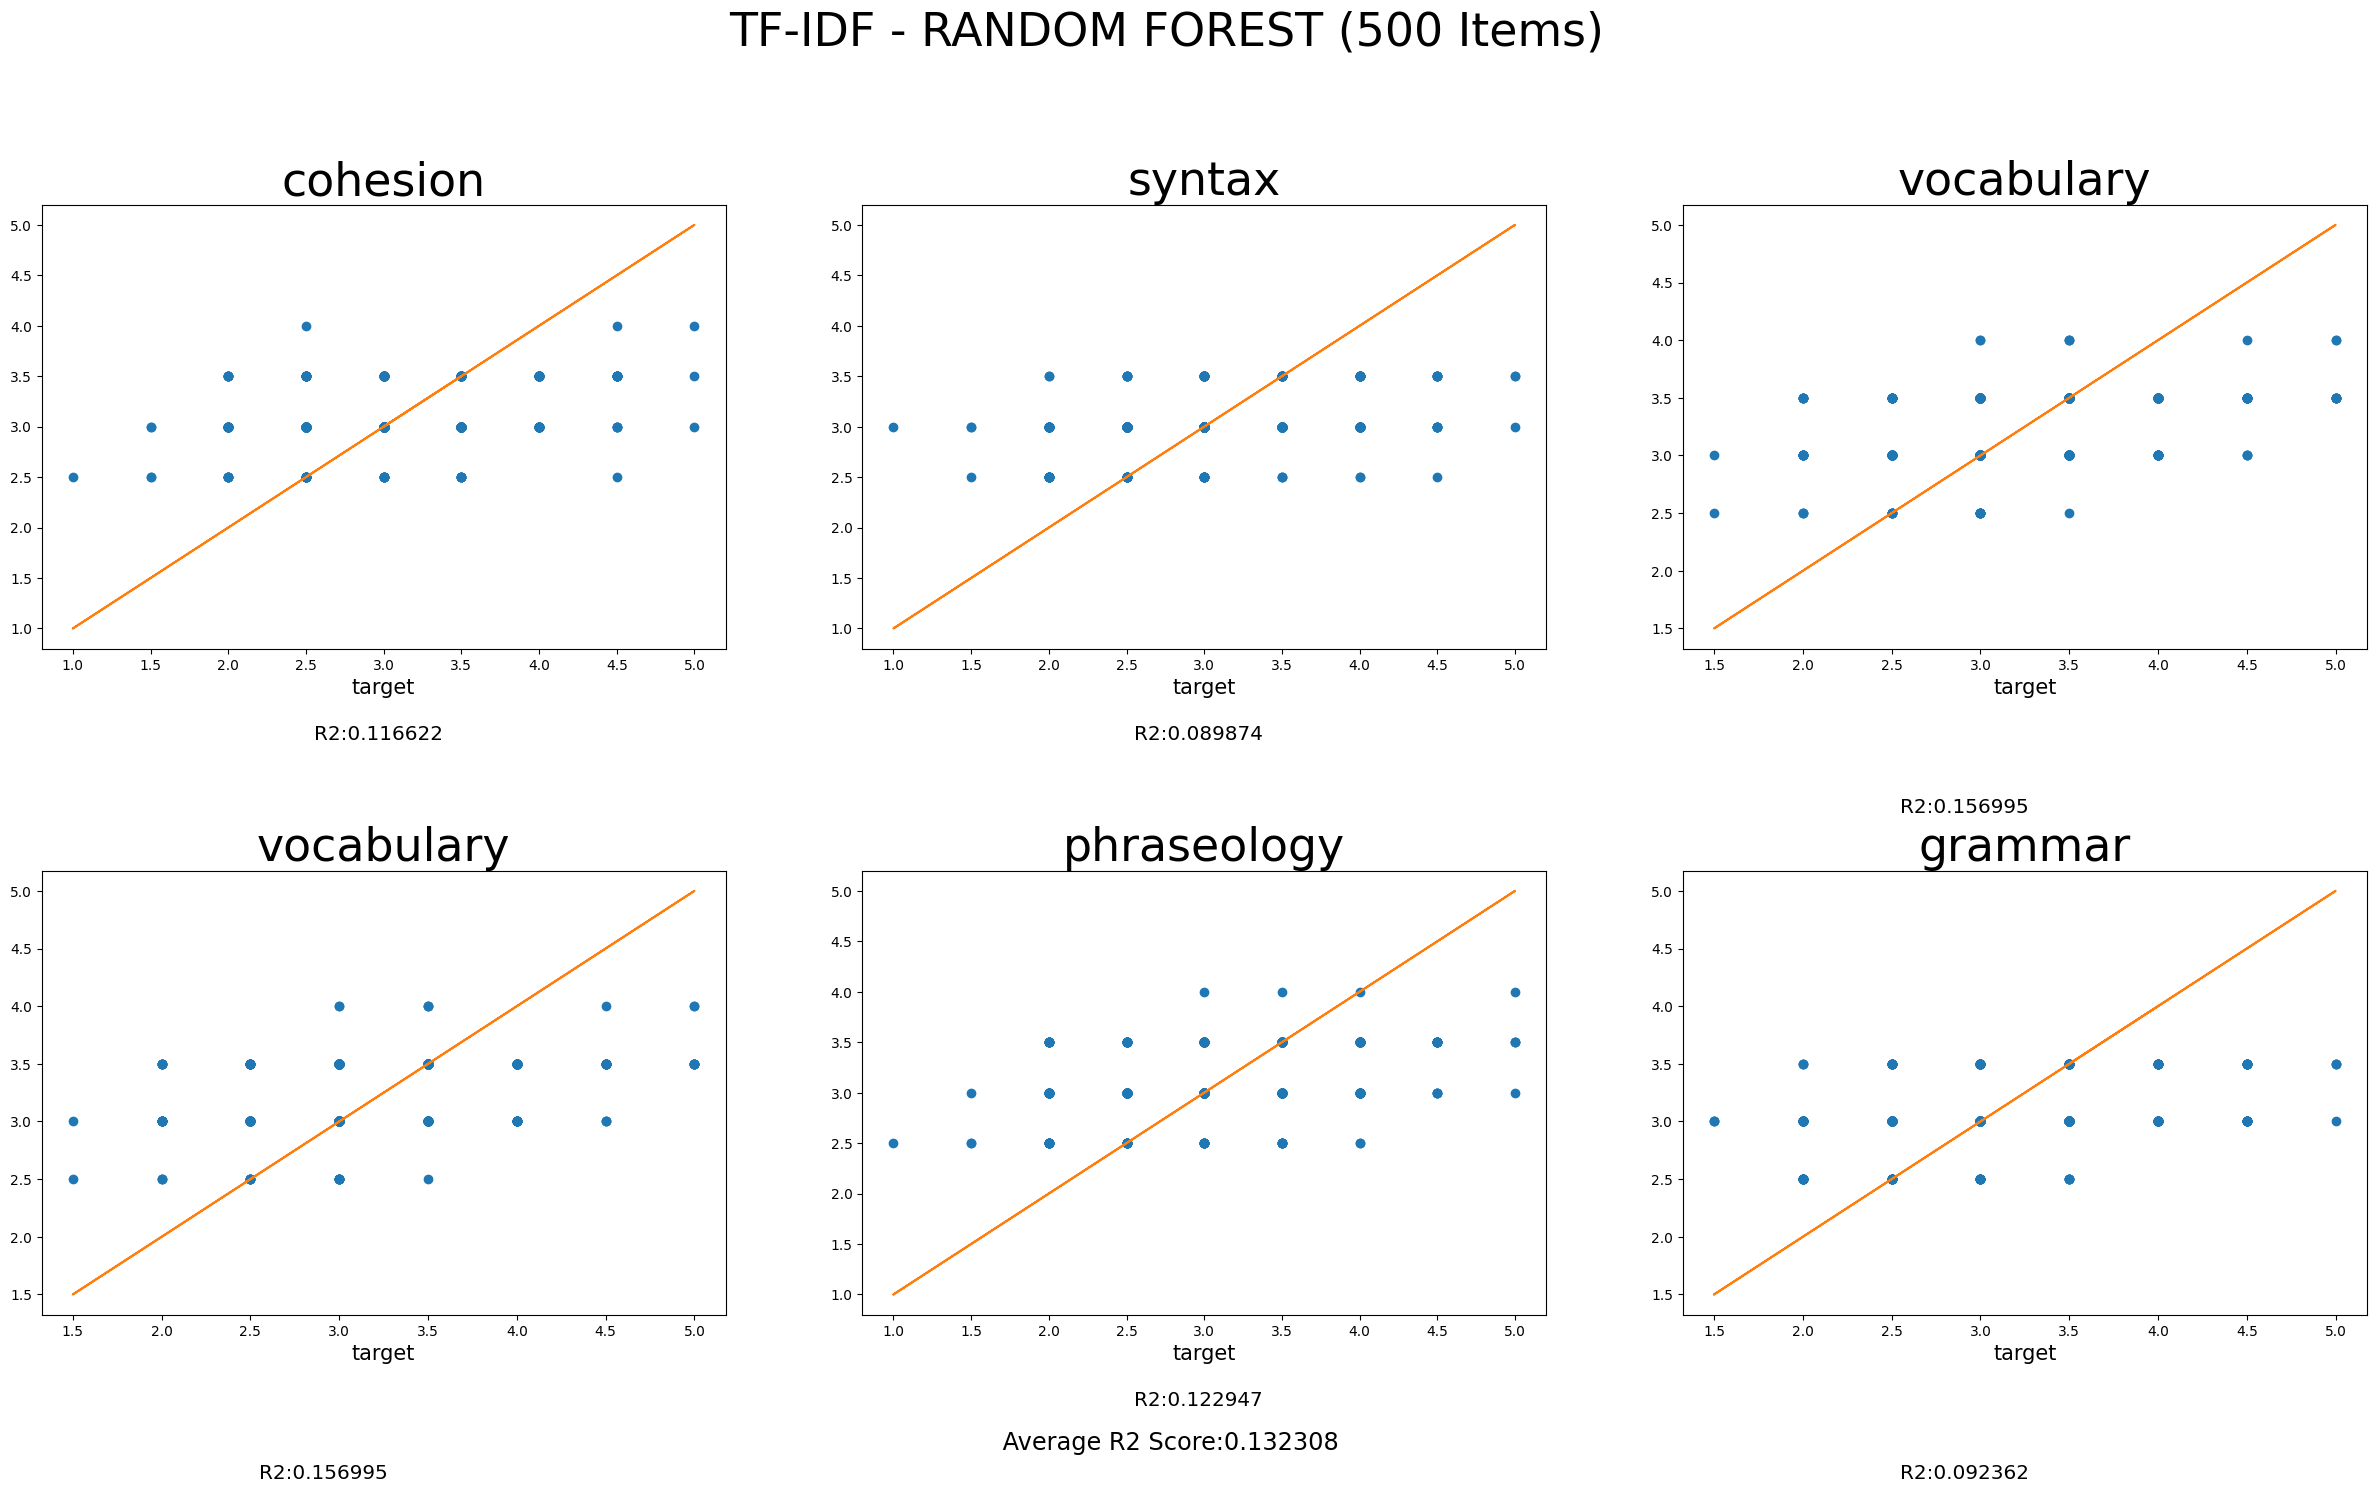

In [27]:
arrs=[
    (["Pred"] *6)+(["Real"] * 6),
    target_names.copy() + target_names.copy()
]  
scaler=StandardScaler()
tarrs=zip(arrs[0],arrs[1])
predictions_index=pd.MultiIndex.from_tuples(tarrs) 
pred_and_y=np.concatenate((predictions,y.to_numpy()),axis=1)
compares=pd.DataFrame(pred_and_y,columns=predictions_index) 
fig,ax =plt.subplots(2,3) 
fig.suptitle(selectedEmbedder + ' - ' + selectedModel + ' (' + str(items) + ' Items)', size=33)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]   
r2=r2_score(y,predictions,multioutput='uniform_average')  
ir2=r2_score(y,predictions,multioutput='raw_values') 
fig.text(0.5,0.02," Average R2 Score:%f"%r2,fontsize="xx-large",ha='center')
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimX)+j
        ax[i,j].plot(compares['Real'][target_names[oneDIndex]],compares['Pred'][target_names[oneDIndex]],"o")  
        ax[i,j].set_title(target_names[oneDIndex],size=33) 
        ax[i,j].set_xlabel("target",size=15) 
        m,b=np.polyfit(y[target_names[oneDIndex]],y[target_names[oneDIndex]],deg=1)
        ax[i,j].plot(y[target_names[oneDIndex]],m*y[target_names[oneDIndex]]+b)
        ax[i,j].text(x=2.55,y=-0.1,s="R2:%f" % ir2[oneDIndex],ma="center",size='x-large')
fig.align_labels()
fig.subplots_adjust(top=0.85,hspace=0.5)  

### transforming to classification for better visualization

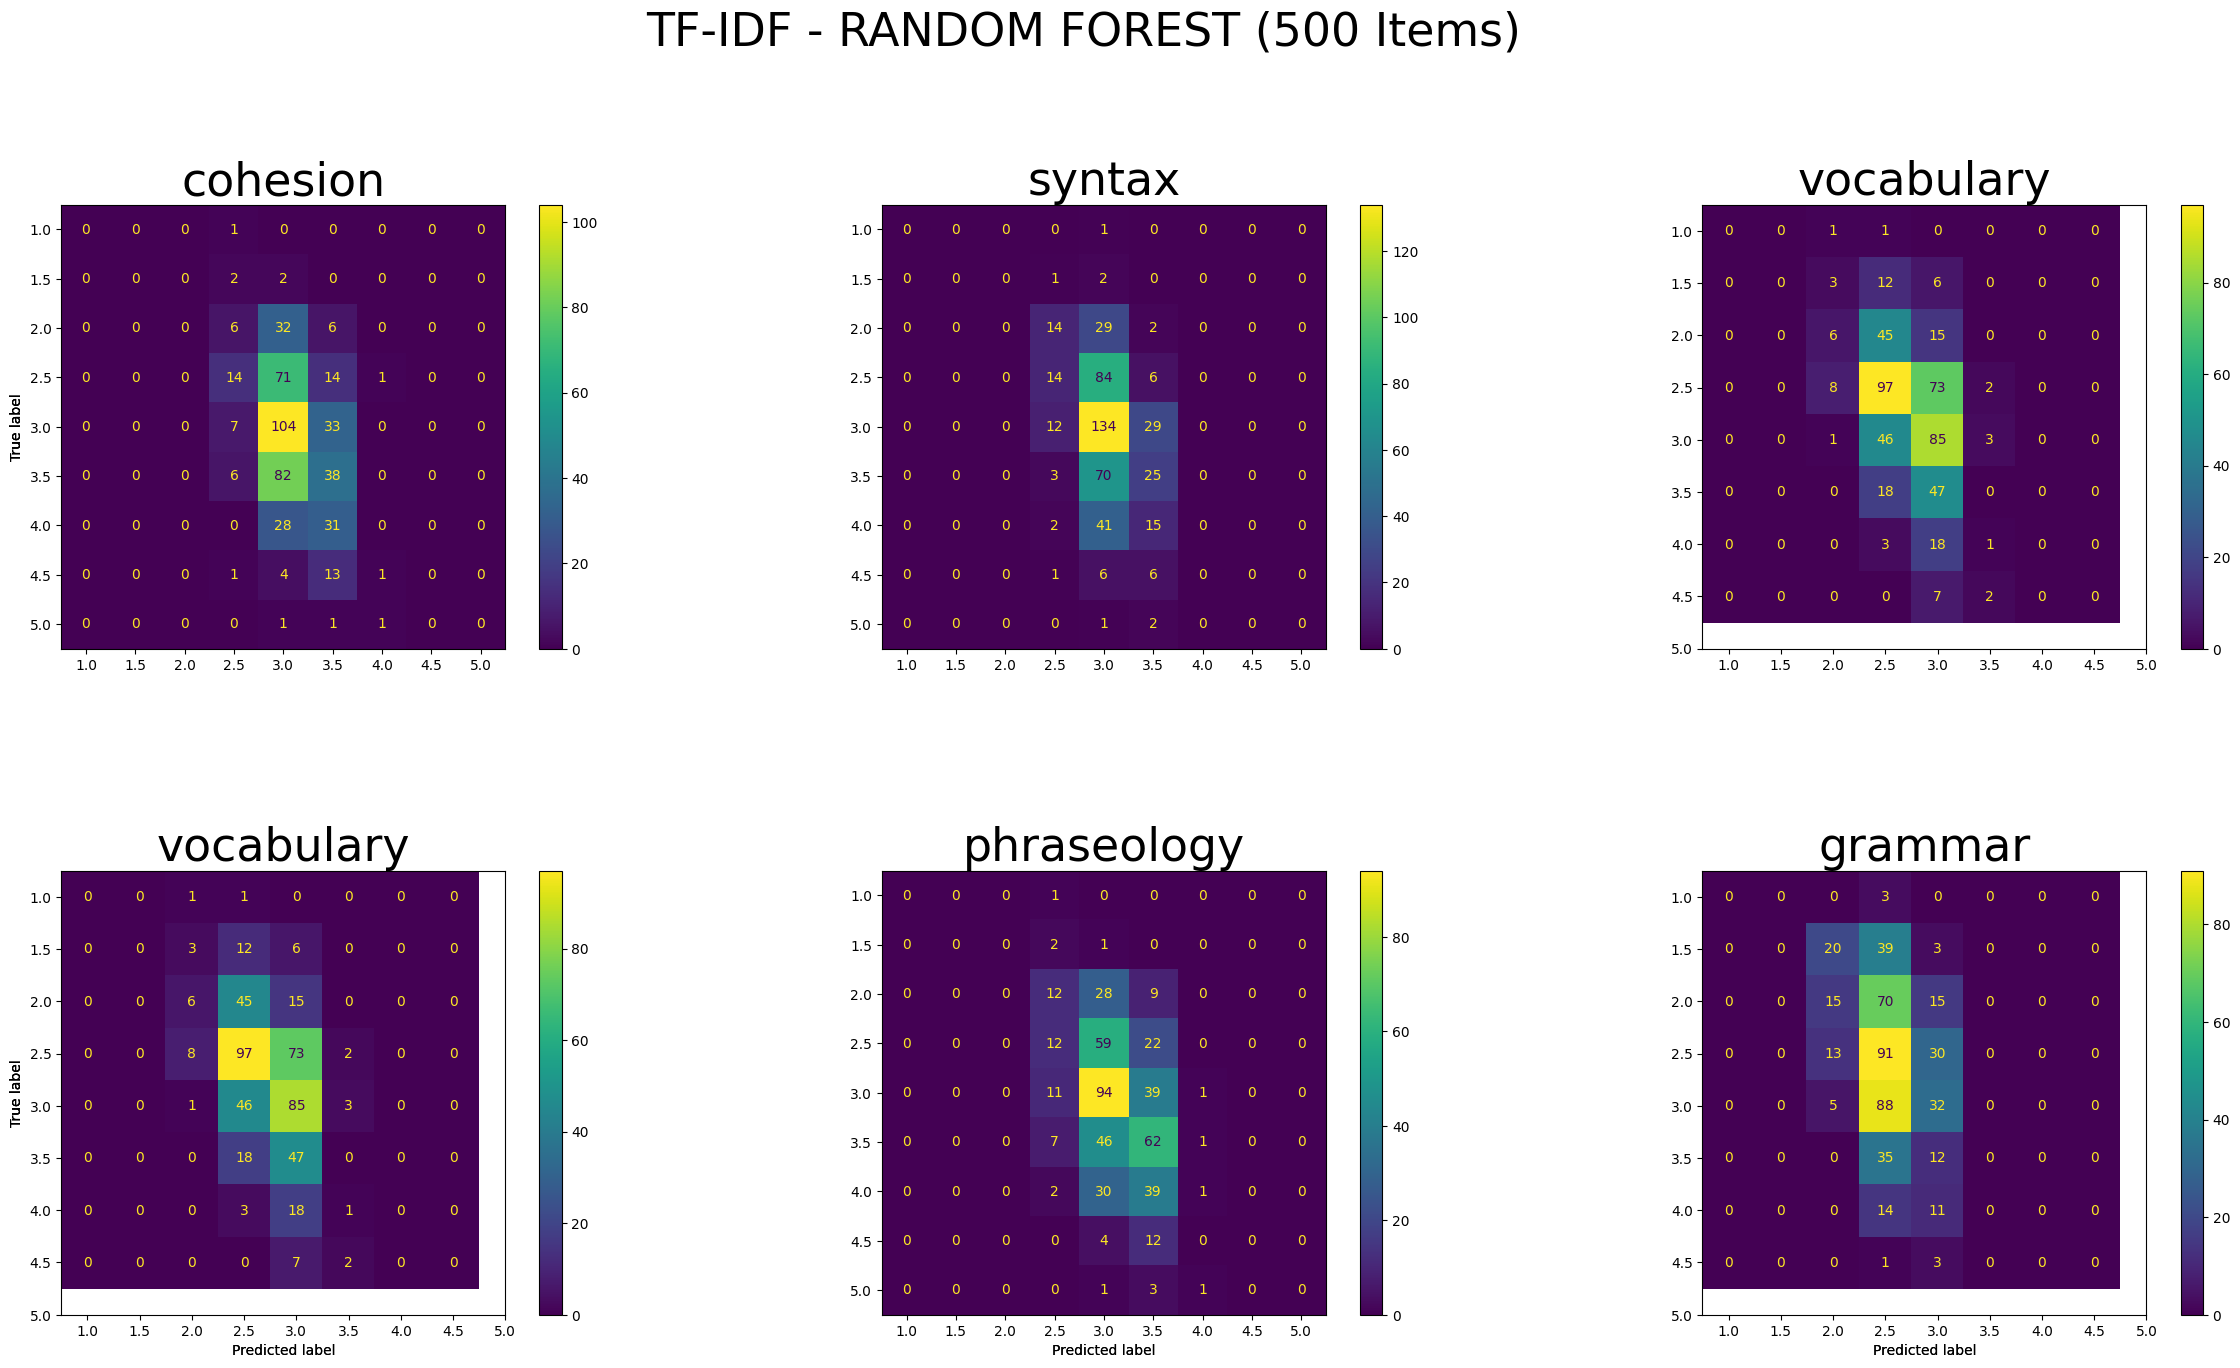

In [28]:
predictions_classifier=[] 
for multiarr in predictions: 
    subaux=[]
    for pred in multiarr:
        subaux.append(str(pred)) 
    predictions_classifier.append(subaux) 
predictions_classifier 
y_classifier=[]
for multiarr in y.to_numpy(): 
    subaux=[] 
    for pred in multiarr:
        subaux.append(str(pred)) 
    y_classifier.append(subaux)  
y_classifier

arrs=[
    (["Pred"] *6)+(["Real"] * 6),
    target_names.copy() + target_names.copy()
]  
scaler=StandardScaler()
tarrs=zip(arrs[0],arrs[1])
predictions_index=pd.MultiIndex.from_tuples(tarrs) 
pred_and_y=np.concatenate((predictions_classifier,y_classifier),axis=1)
compares=pd.DataFrame(pred_and_y,columns=predictions_index) 
fig,ax =plt.subplots(2,3) 
fig.suptitle(selectedEmbedder + ' - ' + selectedModel + ' (' + str(items) + ' Items)',size=33)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]   
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimX)+j 
        cm=confusion_matrix(compares['Real'][target_names[oneDIndex]],compares['Pred'][target_names[oneDIndex]])
        ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax[i,j])
        ax[i,j].set_title(target_names[oneDIndex],size=33) 
        ax[i,j].set_xticks(np.arange(9),labels=np.unique(y_classifier)) 
        ax[i,j].set_yticks(np.arange(9),labels=np.unique(y_classifier)) 
        #ax[i,j].set_xbound(lower=0,upper=350)  
        #centerish=ax[i,j].get_xbound()[1]/2
        #centerishY=ax[i,j].get_ybound()[1]/2
        #ax[i,j].text(x=centerish-13,y=-centerishY/2.5,s=("R2:%f" % float(auxdic[oneDIndex][1])),ma="center")
fig.align_labels() 
# fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5) 

## Running time

In [29]:
end=time.time() 
print(end-start)

2089.9837102890015
